### Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import easydict
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Check CUDA

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Sat Dec 11 06:05:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    30W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load data

Google drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_signal_path = '/content/drive/MyDrive/KIGAM/AnomalyD/data/signal_20190925_175735_046.csv'  # Anomaly
data_noise_path = '/content/drive/MyDrive/KIGAM/AnomalyD/data/noise_20190925_175735_046.csv'  # Normal

### Read data with pandas

In [ ]:
def read_data(loc):
    df = pd.read_csv(loc, header=None)
    df = df.iloc[70:-1,:].reset_index(drop=True, inplace=False)  # 첫 70 + 마지막신호 제거
    return df

In [ ]:
dfNor = read_data(data_noise_path)
dfAno = read_data(data_signal_path)
dfNor.shape, dfAno.shape

((633, 5001), (633, 5001))

### Train test split

- Train  with 80% normal + 10% anomaly
- Test with 20% normal + 90% anomaly

In [ ]:
np.random.seed(777)

In [ ]:
def train_test_split(dfNor, dfAno, nor_ratio=0.8, ano_ratio=0.1):
    NorNum = dfNor.shape[0]
    AnoNum = dfAno.shape[0]
    nor_train_num = int(NorNum*nor_ratio)
    ano_train_num = int(AnoNum*ano_ratio)

    normals = dfNor.values
    anomalies = dfAno.values

    normals = np.take(normals, np.random.rand(normals.shape[0]).argsort(), axis=0)
    anomalies = np.take(anomalies, np.random.rand(anomalies.shape[0]).argsort(), axis=0)

    X_nor_train = normals[:nor_train_num,:]
    Y_nor_train = np.ones((nor_train_num,))
    X_ano_train = anomalies[:ano_train_num,:]
    Y_ano_train = -np.ones((ano_train_num,))
    X_train = np.concatenate([X_nor_train, X_ano_train], axis=0)
    Y_train = np.concatenate([Y_nor_train, Y_ano_train], axis=0)

    X_nor_test = normals[nor_train_num:,:]
    Y_nor_test = np.ones((NorNum-nor_train_num,))
    X_ano_test = anomalies[ano_train_num:,:]
    Y_ano_test = -np.ones((AnoNum-ano_train_num,))
    X_test = np.concatenate([X_nor_test, X_ano_test], axis=0)
    Y_test = np.concatenate([Y_nor_test, Y_ano_test], axis=0)
  
    return X_train, Y_train, X_test, Y_test, nor_train_num

In [ ]:
X_train, Y_train, X_test, Y_test, nor_train_num = train_test_split(dfNor, dfAno)
X_train.shape, X_test.shape

((569, 5001), (697, 5001))

### Normalization

In [ ]:
def data_norm(X, mt='regul'):    
    if mt == 'minmax':
        maximum = np.max(X, axis=1, keepdims=True)
        minimum = np.min(X, axis=1, keepdims=True)
        return (X-minimum) / (maximum-minimum)
    else:
        mean = np.mean(X, axis=1, keepdims=True)
        std = np.std(X, axis=1, keepdims=True)
        return (X-mean) / std

In [ ]:
X_train = data_norm(X_train)
X_test = data_norm(X_test)

### Batches

In [ ]:
def get_batches(X, y, batch_size, shuffle=True):    
    # X = X.values
    sampleNum = X.shape[0];
    batch_num = sampleNum//batch_size;
    if shuffle:
        indices = np.random.permutation(sampleNum)
        X = X[indices,:]
        y = y[indices]        

    for i in range(0, sampleNum, batch_size):
        batchX = X[i:i+batch_size,:]
        batchy = y[i:i+batch_size]   
        
        yield torch.FloatTensor(batchX), torch.FloatTensor(batchy)    

## Deep SVDD

### Pretrain autoencoder 

In [ ]:
class pretrain_autoencoder(nn.Module):
    def __init__(self, z_dim=256):
        super(pretrain_autoencoder,self).__init__()
        self.zdim = z_dim;
        self.encoder_stack = nn.Sequential(
            nn.Linear(5001, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(1024,512, bias=False),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512,z_dim, bias=False)
            )
        self.decoder_stack=nn.Sequential(
            nn.Linear(z_dim,512, bias=False),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512,1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(1024,5001, bias=False)
            )        
        
    def encoder(self,x):
        z = self.encoder_stack(x)
        return z
        
    def decoder(self,x):
        return self.decoder_stack(x)
    
    def forward(self,x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

### DeepSVDD encoder

In [ ]:
class DeepSVDD_network(nn.Module):
    def __init__(self, z_dim=256):
        super(DeepSVDD_network, self).__init__()
        self.zdim = z_dim;
        self.encoder_stack = nn.Sequential(
            nn.Linear(5001,1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            
            nn.Linear(1024,512, bias=False),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512,z_dim, bias=False),
            )

    def forward(self, x):
        z = self.encoder_stack(x)
        return z

## Trainer

### Arguments

In [ ]:
args = easydict.EasyDict({
           'num_epochs':400,
           'num_epochs_ae':800,
           'lr':1e-3,
           'lr_ae':1e-3,
           'weight_decay':5e-5,
           'weight_decay_ae':5e-3,
           'lr_milestones':[50],
           'batch_size':50,
           'train_size':550,       
           'pretrain':True,
           'latent_dim':256,
           'normal_class':0,
           'model_path':'pretrain.pth'
                    })
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Pretrain

In [ ]:
""" DeepSVDD 모델에서 사용할 가중치를 학습시키는 AutoEncoder 학습 단계"""
ae = pretrain_autoencoder(args.latent_dim).to(device)
optimizer = torch.optim.Adam(ae.parameters(), lr=args.lr_ae,
                             weight_decay=args.weight_decay_ae)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                    milestones=args.lr_milestones, gamma=0.1)
        
ae.train()
totStepNum = args.train_size / args.batch_size;
for epoch in range(args.num_epochs_ae):
    total_loss = 0

    for x, _ in get_batches(X_train[:nor_train_num], Y_train[:nor_train_num], batch_size=args.batch_size, shuffle=True):

        x = x.float().to(device)
                
        optimizer.zero_grad()
        x_hat = ae(x)
        reconst_loss = torch.mean(torch.sum((x_hat - x) ** 2, dim=tuple(range(1, x_hat.dim()))))
        reconst_loss.backward()
        optimizer.step()
                
        total_loss += reconst_loss.item()

    scheduler.step()
    print('Pretraining Autoencoder... Epoch: {}, Loss: {:.3f}'.format(
                   epoch+1, total_loss/(args.train_size/args.batch_size)))

Pretraining Autoencoder... Epoch: 1, Loss: 4456.740
Pretraining Autoencoder... Epoch: 2, Loss: 3636.787
Pretraining Autoencoder... Epoch: 3, Loss: 3496.527
Pretraining Autoencoder... Epoch: 4, Loss: 3371.309
Pretraining Autoencoder... Epoch: 5, Loss: 3258.942
Pretraining Autoencoder... Epoch: 6, Loss: 3149.920
Pretraining Autoencoder... Epoch: 7, Loss: 3084.997
Pretraining Autoencoder... Epoch: 8, Loss: 2955.125
Pretraining Autoencoder... Epoch: 9, Loss: 2876.259
Pretraining Autoencoder... Epoch: 10, Loss: 2815.560
Pretraining Autoencoder... Epoch: 11, Loss: 2781.543
Pretraining Autoencoder... Epoch: 12, Loss: 2653.448
Pretraining Autoencoder... Epoch: 13, Loss: 2489.564
Pretraining Autoencoder... Epoch: 14, Loss: 2445.168
Pretraining Autoencoder... Epoch: 15, Loss: 2307.956
Pretraining Autoencoder... Epoch: 16, Loss: 2264.375
Pretraining Autoencoder... Epoch: 17, Loss: 2144.062
Pretraining Autoencoder... Epoch: 18, Loss: 2054.709
Pretraining Autoencoder... Epoch: 19, Loss: 2087.436
Pr

Get center using pretrained autoencoder

In [ ]:
def set_c(model, eps=0.1):
    """Initializing the center for the hypersphere"""
    model.eval()
    z_ = []
    totStepNum = args.train_size/args.batch_size;
    with torch.no_grad():
        for x, _ in get_batches(X_train[:nor_train_num], Y_train[:nor_train_num], batch_size=args.batch_size):
            x = x.float().to(device)
            z = model.encoder(x)
            z_.append(z.detach())

    z_ = torch.cat(z_)
    c = torch.mean(z_, dim=0)
    c[(abs(c) < eps) & (c < 0)] = -eps
    c[(abs(c) < eps) & (c > 0)] = eps
    return c

Save pretrained model

In [ ]:
c = set_c(ae)
net = DeepSVDD_network(args.latent_dim).to(device)
state_dict = ae.state_dict()
net.load_state_dict(state_dict, strict=False)
torch.save({'center': c.cpu().data.numpy().tolist(),
            'net_dict': net.state_dict()}, args.model_path)

### Train

In [ ]:
def train():
    """Deep SVDD model 학습"""
    net = DeepSVDD_network().to(device)
        
    state_dict = torch.load(args.model_path)
    net.load_state_dict(state_dict['net_dict'])
    c = torch.Tensor(state_dict['center']).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=args.lr,
                               weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                    milestones=args.lr_milestones, gamma=0.1)

    net.train()
    totStepNum = args.train_size/args.batch_size;
    for epoch in range(args.num_epochs):
        total_loss = 0        
        for x, y in get_batches(X_train, Y_train, batch_size=args.batch_size, shuffle=True):

            x = x.float().to(device)
            y = y.to(device)
            optimizer.zero_grad()
            z = net(x)
            
            sum_distance = torch.sum((z - c)**2, dim=1)
            loss = torch.mean(sum_distance**y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            
        scheduler.step()
        print('Training Deep SVDD... Epoch: {}, Loss: {:.3f}'.format(
                   epoch+1, total_loss/ (args.train_size/args.batch_size)))
            
    return net, c

In [ ]:
net, c = train()

Training Deep SVDD... Epoch: 1, Loss: 104.780
Training Deep SVDD... Epoch: 2, Loss: 12.437
Training Deep SVDD... Epoch: 3, Loss: 4.526
Training Deep SVDD... Epoch: 4, Loss: 2.593
Training Deep SVDD... Epoch: 5, Loss: 1.716
Training Deep SVDD... Epoch: 6, Loss: 1.290
Training Deep SVDD... Epoch: 7, Loss: 1.244
Training Deep SVDD... Epoch: 8, Loss: 1.046
Training Deep SVDD... Epoch: 9, Loss: 1.153
Training Deep SVDD... Epoch: 10, Loss: 0.921
Training Deep SVDD... Epoch: 11, Loss: 0.946
Training Deep SVDD... Epoch: 12, Loss: 0.872
Training Deep SVDD... Epoch: 13, Loss: 0.907
Training Deep SVDD... Epoch: 14, Loss: 0.961
Training Deep SVDD... Epoch: 15, Loss: 0.726
Training Deep SVDD... Epoch: 16, Loss: 0.745
Training Deep SVDD... Epoch: 17, Loss: 0.644
Training Deep SVDD... Epoch: 18, Loss: 0.730
Training Deep SVDD... Epoch: 19, Loss: 0.822
Training Deep SVDD... Epoch: 20, Loss: 0.699
Training Deep SVDD... Epoch: 21, Loss: 0.760
Training Deep SVDD... Epoch: 22, Loss: 0.537
Training Deep SV

## Eval

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

In [ ]:
def test_eval(net, c, device):
    """Testing the Deep SVDD model"""

    scores = []
    labels = []
    x_list = []
    z_list = []
    net.eval()
    print('Testing...')
    with torch.no_grad():
        stepNum=0;
        for x, y in get_batches(X_test, Y_test, batch_size=4, shuffle=False):
            x = x.float().to(device)
            z = net(x)
            score = torch.mean((z - c) ** 2, dim=1)
          
            x_list.append(x.detach().cpu())
            z_list.append(((z-c)**2).detach().cpu())
            scores.append(score.detach().cpu())
            labels.append(y.cpu())

    x_list = torch.cat(x_list).numpy()
    z_list = torch.cat(z_list).numpy()
    labels, scores = torch.cat(labels).numpy(), torch.cat(scores).numpy()

    return labels, scores, z_list, x_list

In [ ]:
labels, scores, z_list, x_list = test_eval(net, c, device)
labels[labels==1.] = 0  # Normals
labels[labels==-1.] = 1  # Anomalies
labels.shape, scores.shape, z_list.shape

Testing...


((697,), (697,), (697, 256))

In [ ]:
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

### Analysis

- TPR: True Positive Rate, 1인 케이스에 대해 1로 잘 예측한 비율
    - Anomaly (1)를 잘 예측한 비율
- FPR: False Positive Rate, 0인 케이스에 대해 1로 잘못 예측한 비율
    - Normal (0)을 anomaly (1)로 잘못 예측한 비율
- 일반적으로 TPR과 FPR은 비례하며 threshold 별로 TPR/FPR을 나열하여 밑의 면적을 잰 것이 AUC (Area Under the Curve)

In [ ]:
print('ROC AUC score: {:.2f}'.format(roc_auc_score(labels, scores)*100))

ROC AUC score: 99.95


In [ ]:
fpr, tpr, thres = roc_curve(labels, scores)
print('FPR:\n ', fpr)
print('TPR:\n ', tpr)
print('Threshold:\n ', thres)

FPR:
  [0.         0.         0.         0.00787402 0.00787402 0.01574803
 0.01574803 1.        ]
TPR:
  [0.         0.00175439 0.93859649 0.93859649 0.99473684 0.99473684
 1.         1.        ]
Threshold:
  [1.0838547e+00 8.3854690e-02 1.9043896e-02 1.8963499e-02 1.1451536e-02
 1.0300711e-02 4.2670281e-03 6.2090105e-05]


Find threshold 
1. tpr + (1-fpr) is the highest
2. Geometric mean (sqrt(tpr*(1-fpr)))
3. TPR-FPR (J statistics)


In [ ]:
threshold = thres[np.argmax(tpr + (1-fpr))]
#threshold = thres[np.argmax(np.sqrt(tpr*(1-fpr)))]
threshold

0.011451536

What we are interested is False negative (type 2 error)
- 1 (Anomaly) 인데 0 (Normal)로 판단
- 오탐지, (e.g. 스팸메일인데 스팸으로 분류를 못함)

In [ ]:
scores[scores>threshold] = 1.
scores[scores<=threshold] = 0.
scores

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1.

Classification report

In [ ]:
classification_report(labels, scores, output_dict=True)['weighted avg']

{'f1-score': 0.9928588042658663,
 'precision': 0.9929512434533955,
 'recall': 0.9928263988522238,
 'support': 697}

Confusion matrix

In [ ]:
confusion_matrix(labels, scores)

array([[126,   1],
       [  4, 566]])

Label이 1인 것중에 score가 0인 것을 추출

In [ ]:
fn_indices = np.where((labels==1.) & (scores==0.))[0]
x_fn = x_list[fn_indices]
num_nor_test = dfNor.shape[0] - nor_train_num
x_nor_test = x_list[np.random.permutation(num_nor_test)[:len(fn_indices)]]
x_ano_test_indices = []
while len(x_ano_test_indices) < len(fn_indices):
    ano_index = np.random.randint(num_nor_test, len(x_list), size=1)[0]
    if ano_index not in fn_indices:
        x_ano_test_indices.append(ano_index)

x_ano_test = x_list[x_ano_test_indices]
x_fn.shape, x_nor_test.shape, x_ano_test.shape

((4, 5001), (4, 5001), (4, 5001))

Plot

In [ ]:
fig, axes = plt.subplots(nrows=len(fn_indices), ncols=3, sharey='row', figsize=(100,10*len(fn_indices)))
for i, (ano_test, fn, nor_test) in enumerate(zip(x_ano_test, x_fn, x_nor_test)):
    axes[i][0].plot(ano_test, color='r')
    axes[i][0].set_xticks([])
    axes[i][1].plot(fn, color='k')
    axes[i][1].set_xticks([])
    axes[i][2].plot(nor_test, color='b')
    axes[i][2].set_xticks([])
axes[i][0].set_xlabel('Anomalies', fontsize='xx-large')
axes[i][1].set_xlabel('False Negative', fontsize='xx-large')
axes[i][2].set_xlabel('Normals', fontsize='xx-large')
fig.tight_layout();
plt.show();

Output hidden; open in https://colab.research.google.com to view.

### t-SNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
def plot_representations(data, labels):
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels)
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = labels)

In [ ]:
def get_tsne(data, n_components=2):
    tsne = TSNE(n_components=n_components, random_state=908)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

Origin Input

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


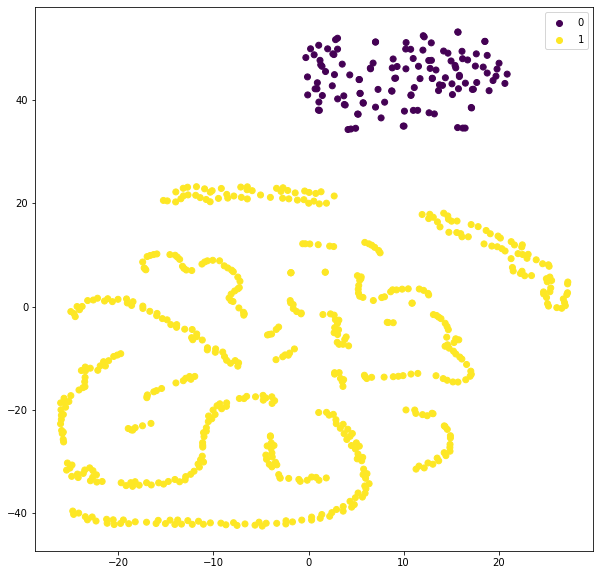

In [ ]:
tsne_data = get_tsne(x_list)
plot_representations(tsne_data, labels)

Representation

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


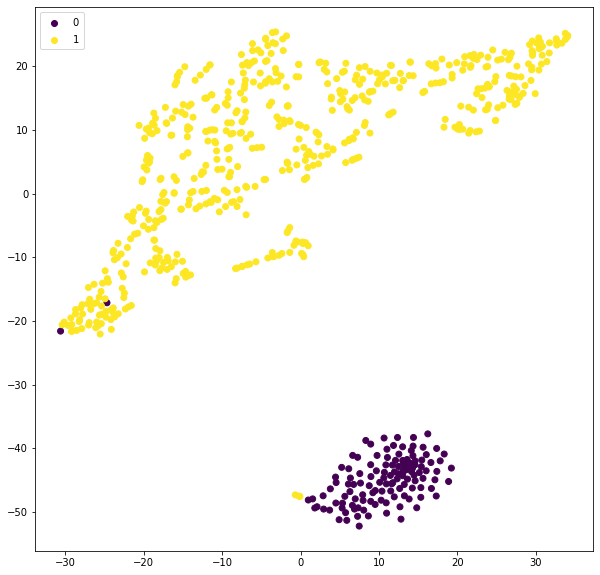

In [ ]:
tsne_data = get_tsne(z_list)
plot_representations(tsne_data, labels)